# Extra Assignment: Transformers and SSMs
Connor Blake, 5/23/25

In [20]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, processors
from sklearn.model_selection import train_test_split
import optax
from rdkit import Chem
from rdkit.Chem import Draw

## Problem 1: Transfomer
Explain, in as much detail as possible, how a Transformer works from the paper [Attention is All You Need](https://arxiv.org/pdf/1706.03762). Be explicit in the use of function signatures, tensor dimensionalities, function definitions.

## Answer 1:



### 1 Notation and Shapes  

* B — batch size  
* T — source-sequence length  
* T′ — target-sequence length  
* H — number of attention heads  
* $d_{\text{model}}$ — model width  
* $d_k = d_{\text{model}} ⁄ H$ — key/query sub-dimension  
* $d_v = d_{\text{model}} ⁄ H$ — value sub-dimension  
* $d_{FF} ≈ 4 d_{\text{model}}$ — hidden width of the feed-forward layer  

Indices  

* b ∈ {0,…,B−1} — sequence in batch  
* t ∈ {0,…,T−1} — source token position  
* t′ ∈ {0,…,T′−1} — target token position  
* h ∈ {0,…,H−1} — head index  
* m ∈ {0,…,d_{\text{model}}−1} — model feature  
* i ∈ {0,…,d_k−1} — key/query feature  
* j ∈ {0,…,d_v−1} — value feature  
* r ∈ {0,…,$d_{\text{FF}}$}-1$ — feed-forward feature  

A tensor element $X_{b t m}$ contains feature $m$ of token $t$ in sequence $b$.

### 2 Primitive Operations  

#### 2.1 Softmax  

$$
\text{softmax}(Z)_{b n} = \frac{e^{Z_{b n}}}{\sum_{n′} e^{Z_{b n′}}}, \quad
Z \in \mathbb R^{B \times N}.
$$

#### 2.2 Layer Normalization  

Given $X_{b t m} ∈ ℝ^{B×T×d}  $

$$
\mu_{b t} = \frac{1}{d} \sum_{m} X_{b t m}, \qquad
\sigma_{b t} = \sqrt{\frac{1}{d} \sum_{m} (X_{b t m} - \mu_{b t})^{2} + \varepsilon},
$$
$$
\text{LayerNorm}(X)_{b t m} =
\frac{X_{b t m} - \mu_{b t}}{\sigma_{b t}} \, \gamma_{m} + \beta_{m},
$$

with learned gain $γ_{m}$ and bias $β_{m}$.

### 3 Scaled Dot-Product Attention  

#### 3.1 Linear projections  

Learn weight matrices  

* $W^{Q}_{m i} ∈ ℝ^{d_{\text{model}}×d_k}$  
* $W^{K}_{m i} ∈ ℝ^{d_{\text{model}}×d_k}  $
* $W^{V}_{m j} ∈ ℝ^{d_{\text{model}}×d_v}$

and form  

$$
Q_{b t i} = X_{b t m} \, W^{Q}_{m i}, \quad
K_{b t i} = X_{b t m} \, W^{K}_{m i}, \quad
V_{b t j} = X_{b t m} \, W^{V}_{m j}.
$$

Split the last index into H heads:  
$Q_{b t h i}, K_{b t h i} ∈ ℝ^{B×T×H×d_k}; V_{b t h j} ∈ ℝ^{B×T×H×d_v}$.

#### 3.2 Attention kernel and weights  

$$
S_{b h t_q t_k} = \frac{1}{\sqrt{d_k}}
\, Q_{b t_q h i} \, K_{b t_k h i}.
$$

For decoder self-attention, entries with $t_k > t_q$ are set to $-\infty$.

$$
\alpha_{b h t_q t_k} = \text{softmax}_{t_k} \bigl( S_{b h t_q t_k} \bigr).
$$

#### 3.3 Head output and combination  

$$
Z_{b t_q h j} = \alpha_{b h t_q t_k} \, V_{b t_k h j}.
$$

Concatenate heads as $Z_{b t n}$ with $n = h d_v + j$ and project

$$
\tilde Z_{b t m} = Z_{b t n} \, W^{O}_{n m},
\qquad W^{O} \in \mathbb R^{H d_v \times d_{\text{model}}}.
$$


### 4 Position-wise Feed-Forward Network  

$$
\tilde X_{b t r} = \max \bigl( 0, \, X_{b t m} W^{(1)}_{m r} + b^{(1)}_{r} \bigr),
$$
$$
Y_{b t m} = \tilde X_{b t r} \, W^{(2)}_{r m} + b^{(2)}_{m},
\qquad
W^{(1)} \in \mathbb R^{d_{\text{model}} \times d_{ff}},
\; W^{(2)} \in \mathbb R^{d_{ff} \times d_{\text{model}}}.
$$


### 5 Positional Encoding  

For position $t$ and feature $m$,

$$
\text{PE}_{t m} =
\begin{cases}
\sin \bigl( t / 10000^{\,2m / d_{\text{model}}} \bigr) & m \text{ even}, \\[6pt]
\cos \bigl( t / 10000^{\,2m / d_{\text{model}}} \bigr) & m \text{ odd}.
\end{cases}
$$

Add $PE_{t m}$ to token embeddings $E_{t m}$.

### 6 Encoder Layer  

With input $X^{(l)}_{b t m}$

1. Multi-head self-attention  
   $$ \hat Z_{b t m} = \text{MHA} \bigl( \text{LayerNorm}(X^{(l)}) \bigr)_{b t m}. $$
2. Residual add $Z_{b t m} = X^{(l)}_{b t m} + \hat Z_{b t m}$.  
3. Feed-forward  
   $$ \hat Y_{b t m} = \text{FFN} \bigl( \text{LayerNorm}(Z) \bigr)_{b t m}. $$
4. Residual add $X^{(l+1)}_{b t m} = Z_{b t m} + \hat Y_{b t m}$.

Repeat for $l = 0,…,L_E−1$; final output is memory $M_{b t m}$.


### 7 Decoder Layer  

With decoder input $Y^{(l)}_{b t′ m}$ and memory $M_{b t m}$

1. Masked self-attention  
   $$ \hat U = \text{MHA}_{\text{masked}} \bigl( \text{LayerNorm}(Y^{(l)}) \bigr). $$
2. $U = Y^{(l)} + \hat U$.  
3. Cross-attention  
   $$ \hat V = \text{MHA} \bigl( Q = \text{LayerNorm}(U),\, K = M,\, V = M \bigr). $$
4. $V = U + \hat V$.  
5. Feed-forward  
   $$ \hat Y = \text{FFN} \bigl( \text{LayerNorm}(V) \bigr). $$
6. $Y^{(l+1)} = V + \hat Y$.

Repeat for $l = 0,\ldots,L_D−1$.

### 8 End-to-End Forward Pass  

1. Encode the source to obtain memory $M_{b t m}$.  
2. Decode shifted-right targets with causal masking while attending to $M_{b t m}$.  
3. Project decoder states with $W^{\text{vocab}}_{m v}$ and apply softmax to obtain  
   $$ p(y_{t′} \mid y_{<t′}, x). $$


### 9 Training Objective  

$$
\mathcal L = -\sum_{b,\,t′} \log p \bigl( y_{t′}^{(b)} \mid y_{<t′}^{(b)},\, x^{(b)} \bigr),
$$

minimised with Adam using learning-rate warm-up and inverse-square-root decay.

### 10 Parameter and Complexity Summary  

| sub-unit | parameters | time per layer | space per layer |
|----------|------------|----------------|-----------------|
| multi-head attention | $3 d_{\text{model}} d_k H + d_{\text{model}} d_v H$ | $O(B T^{2} d_k)$ | $O(B T d_{\text{model}})$ |
| feed-forward | $2 d_{\text{model}} d_{\text{FF}}$ | $O(B T d_{\text{FF}})$ | $O(B T d_{\text{FF}})$ |
| layer norm | $2 d_{\text{model}}$ | negligible | negligible |



## Problem 2 ChemBERTa:
This problem is based on the [ChemBERTa](https://arxiv.org/pdf/2010.09885) paper.
### a)
Load the file `250k_rndm_zinc_drugs_clean_3.csv` and set up a word-level tokenizer with a byte-level pre tokenizer. Explain what these mean and why they are needed.
### b)
Using this tokenizer, pick a nontrivial SMILES string. Print out the string, the tokenization, and use rdkit to display it.
### c)
Set up a train/test loader using BERT-style masking. Explain why there must be collation.
### d)
Set up and define a Transformer class, a Masked Transformer class, masking function and optimizers. Explain why a Masked Transformer is needed. Choose a loss function and justify it.
### e) 
Train the BERT-style model for a number of epochs until the loss is consistently less than ~3. Use the model to predict a previously-unseen SMILES string, and print out both the model, the masked, and the predicted. Qualitatively describe what's happening.

## Answer 2:

### a)

In [3]:
df_full = pd.read_csv('250k_rndm_zinc_drugs_clean_3.csv')
df = df_full.iloc[:10000]
smiles = df['smiles'].tolist()

In [4]:
tokenizer = Tokenizer(models.WordLevel(unk_token='[UNK]'))
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
trainer = trainers.WordLevelTrainer(vocab_size=1000,
    special_tokens=['[PAD]','[UNK]','[CLS]','[SEP]','[MASK]'])
tokenizer.train_from_iterator(smiles, trainer=trainer)
tokenizer.post_processor = processors.TemplateProcessing(
    '[CLS] $A [SEP]', special_tokens=[('[CLS]',1),('[SEP]',2)])
tokenizer.enable_truncation(max_length=64)

Byte-level guarantees that every character is representable. Word-level allows the model to parse more complex strings like "Cl","=O" as a single item.

### b)

Cc1occc1C(=O)NC1CCN(C(=O)C(=O)Nc2ccc(F)cc2F)CC1

['[CLS]', 'ĠCc', '1', 'occc', '1', 'C', '(=', 'O', ')', 'NC', '1', 'CCN', '(', 'C', '(=', 'O', ')', 'C', '(=', 'O', ')', 'Nc', '2', 'ccc', '(', 'F', ')', 'cc', '2', 'F', ')', 'CC', '1', 'Ċ', '[SEP]']
[1, 32, 7, 216, 7, 6, 12, 10, 5, 29, 7, 52, 8, 6, 12, 10, 5, 6, 12, 10, 5, 35, 9, 18, 8, 26, 5, 17, 9, 26, 5, 23, 7, 13, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


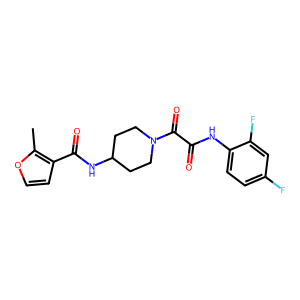

In [21]:
smiles0 = smiles[2100]
print(smiles0)
encoding0 = tokenizer.encode(smiles0)
print(encoding0.tokens)
print(encoding0.ids)
print(encoding0.attention_mask)
mol=Chem.MolFromSmiles(smiles0)
Draw.MolToImage(mol)

### c)

In [6]:
enc = {'input_ids':[], 'attention_mask':[]}
for e in tokenizer.encode_batch(smiles): # tokenizes each
    enc['input_ids'].append(e.ids)
    enc['attention_mask'].append(e.attention_mask)
ids = enc['input_ids']
masks = enc['attention_mask']
# train test split
ids_train, ids_test, masks_train, masks_test = train_test_split(
    ids, masks, test_size=0.1, random_state=42
)
# packs into dicts
train_enc = {'input_ids': ids_train, 'attention_mask': masks_train}
test_enc  = {'input_ids': ids_test,  'attention_mask': masks_test}

In [7]:
# dataset custom class
class SMILESDataset(Dataset):
    def __init__(self, enc):
        self.ids = enc['input_ids']
        self.mask = enc['attention_mask']
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.ids[i], dtype=torch.long),
            'attention_mask': torch.tensor(self.mask[i], dtype=torch.long)
        }

In [8]:
def collate_fn(batch):
    # this must exist to pad them all to the same length so they can be stacked and passed into transfomer
    ids = [item['input_ids'] for item in batch]
    masks = [item['attention_mask'] for item in batch]
    pad_id = tokenizer.token_to_id('[PAD]')
    ids_padded = pad_sequence(ids, batch_first=True, padding_value=pad_id)
    masks_padded = pad_sequence(masks, batch_first=True, padding_value=0)
    return {'input_ids': ids_padded, 'attention_mask': masks_padded}

Not all SMILES strings are the same length, so they must be padded to use standord uniform size tensor frameworks.

In [9]:
train_loader = DataLoader(
    SMILESDataset(train_enc),
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    SMILESDataset(test_enc),
    batch_size=32,
    collate_fn=collate_fn
)

### d)

In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, mlp_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, num_heads)
        self.ln1 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(nn.Linear(d_model, mlp_dim),
                                 nn.GELU(),
                                 nn.Linear(mlp_dim, d_model))
        self.ln2 = nn.LayerNorm(d_model)
    def forward(self, x, mask):
        attn_out, _ = self.attn(x, x, x, key_padding_mask=mask==0)
        x = x + attn_out
        y = self.ln1(x)
        x = x + self.mlp(y)
        return self.ln2(x)

In [12]:
class MaskedTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=64, num_heads=4,
                 mlp_dim=128, num_layers=3):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, mlp_dim)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(d_model, vocab_size)
    def forward(self, input_ids, mask):
        x = self.embed(input_ids).transpose(0, 1)
        for layer in self.layers:
            x = layer(x, mask)
        return self.fc(x).transpose(0, 1)

The attention mask is a way to tell the Transformer which positions in the input are “real” tokens and which are just padding or otherwise shouldn’t contribute to attention

In [13]:
def mask_inputs(ids, mask_token_id, mask_prob=0.15):
    labels = ids.clone()
    rand = torch.rand(ids.shape)
    mask_positions = rand < mask_prob
    labels[~mask_positions] = -100
    ids[mask_positions] = mask_token_id
    return ids, labels

In [14]:
vocab_size = tokenizer.get_vocab_size()
model = MaskedTransformer(vocab_size)
opt = optim.Adam(model.parameters(), lr=1e-4)
crit = nn.CrossEntropyLoss(ignore_index=-100)

Cross entropy is a good choice for multiclass classification where there are probabilistic predictions. It is always positive and is uniquely minimized when fully confident correct answers are given.

### e)

In [15]:
for epoch in range(10):
    for batch in train_loader:
        ids, labels = mask_inputs(batch['input_ids'], tokenizer.token_to_id('[MASK]'))
        masks = batch['attention_mask']
        opt.zero_grad()
        logits = model(ids, masks)
        loss = crit(logits.reshape(-1, vocab_size), labels.reshape(-1))
        loss.backward()
        opt.step()
        print(f"\t batch, loss = {loss:.3f}")
    print(f"Epoch = {epoch}")

	 batch, loss = 6.604
	 batch, loss = 6.601
	 batch, loss = 6.576
	 batch, loss = 6.525
	 batch, loss = 6.443
	 batch, loss = 6.402
	 batch, loss = 6.405
	 batch, loss = 6.319
	 batch, loss = 6.276
	 batch, loss = 6.280
	 batch, loss = 6.198
	 batch, loss = 6.273
	 batch, loss = 6.195
	 batch, loss = 6.073
	 batch, loss = 6.038
	 batch, loss = 6.067
	 batch, loss = 6.057
	 batch, loss = 5.842
	 batch, loss = 6.023
	 batch, loss = 5.902
	 batch, loss = 5.951
	 batch, loss = 5.935
	 batch, loss = 5.783
	 batch, loss = 5.842
	 batch, loss = 5.779
	 batch, loss = 5.724
	 batch, loss = 5.604
	 batch, loss = 5.780
	 batch, loss = 5.871
	 batch, loss = 5.274
	 batch, loss = 5.747
	 batch, loss = 5.668
	 batch, loss = 5.705
	 batch, loss = 5.406
	 batch, loss = 5.473
	 batch, loss = 5.162
	 batch, loss = 5.528
	 batch, loss = 5.342
	 batch, loss = 5.199
	 batch, loss = 5.176
	 batch, loss = 5.117
	 batch, loss = 5.092
	 batch, loss = 5.262
	 batch, loss = 5.274
	 batch, loss = 4.990
	 batch, l

KeyboardInterrupt: 

In [67]:
torch.save(model.state_dict(), 'masked_transformer_weights.pth')

model = MaskedTransformer(vocab_size)
model.load_state_dict(torch.load('masked_transformer_weights.pth'))
model.eval()

MaskedTransformer(
  (embed): Embedding(517, 64)
  (layers): ModuleList(
    (0-2): 3 x TransformerBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=128, out_features=64, bias=True)
      )
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (fc): Linear(in_features=64, out_features=517, bias=True)
)

#### Mini Example

In [71]:
import pandas as pd
import torch

# 1. Load the 10 000th SMILES
df_full = pd.read_csv('250k_rndm_zinc_drugs_clean_3.csv')
smiles_orig = df_full.iloc[10001]['smiles']  # zero-based index

# 2. Encode and build batch
encoding = tokenizer.encode(smiles_orig)
input_ids = torch.tensor(encoding.ids).unsqueeze(0)           # shape [1, L]
attention_mask = torch.tensor(encoding.attention_mask).unsqueeze(0)

# 3. Apply masking
mask_id = tokenizer.token_to_id('[MASK]')
ids_masked, _ = mask_inputs(input_ids.clone(), mask_id, mask_prob=0.15)

# 4. Forward pass
model.eval()
with torch.no_grad():
    logits = model(ids_masked, attention_mask)               # [1, L, V]
    preds = logits.argmax(dim=-1).squeeze(0).tolist()         # [L]

# 5. Decode back to tokens → SMILES
tokens_pred = [tokenizer.id_to_token(i) for i in preds]
# strip off [CLS]/[SEP] and join
smiles_pred = ''.join(tok for tok in tokens_pred if tok not in ('[CLS]','[SEP]','[PAD]'))

print("Original: ", smiles_orig)
print("Masked  : ", ''.join(
    tokenizer.id_to_token(i) if i!=mask_id else '[MASK]'
    for i in ids_masked.squeeze(0).tolist()))
print("Predicted:", smiles_pred)


Original:  CC(C)c1cc(C(=O)Nc2ccc(C[NH+]3CCCC3)cc2)n[nH]1

Masked  :  [UNK]ĠCC(C[MASK]c1[MASK](C(=[MASK])Nc2ccc[MASK]C[NH+]3CCCC3)cc2)n[[MASK][MASK]1[MASK][CLS]
Predicted: ĠCCĊ)ĊĊn)()OO)sĠOn1(nCSCCOOOĊ)


While it's mostly predicting garbage, it has understood some common features like starting the chain with 2 carbons etc. This poor performance is mostly to be expected for such a small dataset and ~5 epochs with shallow nets and small batches, but I can see the shape of the structure starting form.

## Problem 3: Lyra